In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import sklearn
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
import pymorphy2
from nltk.probability import FreqDist
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from scipy.stats import multivariate_normal as mvn
import datetime

In [243]:
%matplotlib inline

In [38]:
stopwords = nltk.corpus.stopwords.words('russian') + \
                        nltk.corpus.stopwords.words('english')

stopwords = stopwords + ['это', 'этот'] 
lemma = WordNetLemmatizer()
morph = pymorphy2.MorphAnalyzer()


def clear_data(string, deep=False):
    string = re.sub('\n', '', string)
    string = re.sub('\t', ' ', string) 
    #string = re.sub(r'((?=[A-ZА-Я][a-zа-я]+)|((?<=[a-zа-я])(?=[A-ZА-Я])))', r' ', string)
    #string = re.sub(r'((?<=[a-zа-я])(?=[1-9]))', r' ', string)
    string = re.sub('[^A-Za-zА-Яа-я0-9]+', ' ', string) # Оставляем только буквы и цифры

    tokens = nltk.word_tokenize(string) # Разбиваем на токены
    if deep:
        tokens = [word.lower() for word in tokens] # Нижний регистр
        tokens = [word for word in tokens if word not in stopwords and len(word) > 1] # Убираем стоп-слова
        tokens = [lemma.lemmatize(word) for word in tokens] # Лемма
        tokens = [morph.parse(word)[0].normal_form for word in tokens]

    string = ' '.join(tokens) # Собираем в строку
    return string

In [3]:
def count_transform(string):
    string = string.replace('.', '')
    if string.endswith('K'):
        string = string.replace('K', '')
        n = int(string) * 1000
    elif string.endswith('M'):
        string = string.replace('M', '')
        string = string.replace('M', '')
        n = int(string) * 1000000
    else:
        n = int(string)
    
    return n

In [164]:
def get_names(string):
    string_list = re.findall(r'[A-Z]{2,}|[A-Z][a-z]{1,}', string)
    string_list = [word for word in string_list if word.lower() not in stopwords]
    string_list = [lemma.lemmatize(word) for word in string_list]
    string_list = [morph.parse(word)[0].normal_form for word in string_list]
    return string_list

In [5]:
df = pd.read_csv('F:/Otus_courses/Machine Learning_Professional_2021/Project_final/habr.csv', index_col=0) 

## EDA

In [92]:
df.head()

,href,dt,article_text,score,bookmark,comment,view,user,hub_tags
0,https://habr.com/ru/company/skillfactory/blog/...,2022-05-26T20:48:38.000Z,В конце 2018 года в nVidia выпустили первую St...,15,23,0,2.9K,Picard,"skillfactory,python,gan,стиль,программирование..."
1,https://habr.com/ru/company/habr_career/blog/6...,2022-05-26T13:18:03.000Z,В прошлом месяце на Хабр Карьере завершилась в...,15,19,1,2.7K,habr_career,"спецпроект хабр карьеры,неделя аналитиков,спец..."
2,https://habr.com/ru/company/hh/blog/667856/,2022-05-26T09:48:47.000Z,Встретились как-то продакт с дата-сайентистом ...,3,8,2,1.2K,ne_volshebnik,"data,product management,data science,дата-сайе..."
3,https://habr.com/ru/company/avito/blog/667892/,2022-05-26T08:00:03.000Z,Открыт приём заявок на новый поток Академии Ан...,1,5,0,2K,Asphaltoozy,"авито,аналитика,данные,курсы,обучение,python,m..."
4,https://habr.com/ru/company/rubda/blog/667788/,2022-05-25T12:58:13.000Z,Современное машинное обучение не только перени...,0,8,0,633,RUBDA,"ассоциация больших данных,automl,bigdata,машин..."


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3841 entries, 0 to 3840
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   href          3841 non-null   object
 1   dt            3841 non-null   object
 2   article_text  2663 non-null   object
 3   score         3841 non-null   int64 
 4   bookmark      3841 non-null   int64 
 5   comment       3841 non-null   int64 
 6   view          3841 non-null   object
 7   user          3841 non-null   object
 8   hub_tags      3835 non-null   object
dtypes: int64(3), object(6)
memory usage: 300.1+ KB


In [6]:
df = df.dropna(subset=['article_text'])
df = df.drop_duplicates(subset = ['href'])

In [95]:
df.head()

,href,dt,article_text,score,bookmark,comment,view,user,hub_tags
0,https://habr.com/ru/company/skillfactory/blog/...,2022-05-26T20:48:38.000Z,В конце 2018 года в nVidia выпустили первую St...,15,23,0,2.9K,Picard,"skillfactory,python,gan,стиль,программирование..."
1,https://habr.com/ru/company/habr_career/blog/6...,2022-05-26T13:18:03.000Z,В прошлом месяце на Хабр Карьере завершилась в...,15,19,1,2.7K,habr_career,"спецпроект хабр карьеры,неделя аналитиков,спец..."
2,https://habr.com/ru/company/hh/blog/667856/,2022-05-26T09:48:47.000Z,Встретились как-то продакт с дата-сайентистом ...,3,8,2,1.2K,ne_volshebnik,"data,product management,data science,дата-сайе..."
3,https://habr.com/ru/company/avito/blog/667892/,2022-05-26T08:00:03.000Z,Открыт приём заявок на новый поток Академии Ан...,1,5,0,2K,Asphaltoozy,"авито,аналитика,данные,курсы,обучение,python,m..."
4,https://habr.com/ru/company/rubda/blog/667788/,2022-05-25T12:58:13.000Z,Современное машинное обучение не только перени...,0,8,0,633,RUBDA,"ассоциация больших данных,automl,bigdata,машин..."


In [58]:
df['dt'] = pd.to_datetime(df['dt'], format='%Y-%m-%d', exact=False)
df['dt_today'] = datetime.datetime.now()
df['days'] = (df['dt_today'].dt.date - df['dt'].dt.date).dt.days

In [8]:
df['article_text'] = df['article_text'].apply(clear_data)
df['view'] = df['view'].apply(count_transform)

In [59]:
df['view_day'] = df['view'] / df['days']
df['score_day'] = df['score'] / df['days']
df['bookmark_day'] = df['bookmark'] / df['days']
df['comment_day'] = df['comment'] / df['days']

In [62]:
df.columns

Index(['href', 'dt', 'article_text', 'score', 'bookmark', 'comment', 'view',
       'user', 'hub_tags', 'ym', 'article_names', 'article_text_new',
       'article_text_split', 'dt_today', 'days', 'view_day', 'score_day',
       'bookmark_day', 'comment_day'],
      dtype='object')

In [98]:
df.describe()

,score,bookmark,comment,view
count,1947.000000,1947.000000,1947.000000,1947.000000
mean,10.413970,36.353364,10.971751,30085.706215
std,16.671827,46.556803,42.489582,24497.683998
min,-47.000000,0.000000,0.000000,102.000000
25%,3.000000,11.000000,0.000000,13000.000000
50%,6.000000,23.000000,3.000000,24000.000000
75%,13.000000,43.000000,9.000000,42000.000000
max,247.000000,641.000000,1152.000000,150000.000000


In [99]:
df

,href,dt,article_text,score,bookmark,comment,view,user,hub_tags
0,https://habr.com/ru/company/skillfactory/blog/...,2022-05-26 20:48:38+00:00,В конце 2018 года в nVidia выпустили первую St...,15,23,0,29000,Picard,"skillfactory,python,gan,стиль,программирование..."
1,https://habr.com/ru/company/habr_career/blog/6...,2022-05-26 13:18:03+00:00,В прошлом месяце на Хабр Карьере завершилась в...,15,19,1,27000,habr_career,"спецпроект хабр карьеры,неделя аналитиков,спец..."
2,https://habr.com/ru/company/hh/blog/667856/,2022-05-26 09:48:47+00:00,Встретились как то продакт с дата сайентистом ...,3,8,2,12000,ne_volshebnik,"data,product management,data science,дата-сайе..."
3,https://habr.com/ru/company/avito/blog/667892/,2022-05-26 08:00:03+00:00,Открыт при м заявок на новый поток Академии Ан...,1,5,0,2000,Asphaltoozy,"авито,аналитика,данные,курсы,обучение,python,m..."
4,https://habr.com/ru/company/rubda/blog/667788/,2022-05-25 12:58:13+00:00,Современное машинное обучение не только перени...,0,8,0,633,RUBDA,"ассоциация больших данных,automl,bigdata,машин..."
...,...,...,...,...,...,...,...,...,...
3808,https://habr.com/ru/post/487940/,2020-02-11 13:43:48+00:00,Достаточно часто возникает потребность проведе...,8,22,0,17000,i_shutov,"data science,Data Mining,R,Data Engineering"
3813,https://habr.com/ru/post/478688/,2020-01-28 09:18:20+00:00,Я слышал что за советом к тебе Спасибо за встр...,7,72,8,17000,NapoleonIT,"data science,machine learning,Data Engineering"
3817,https://habr.com/ru/company/newprolab/blog/482...,2019-12-27 08:35:50+00:00,Привет Мы обучаем людей работе с большими данн...,4,16,3,12000,a-pichugin,"mcs,mail.ru cloud solutions,ambari,autoscaling..."
3822,https://habr.com/ru/company/dododev/blog/475476/,2019-11-13 15:37:37+00:00,Привет Хабр Мы в Dodo Pizza Engineering очень ...,15,63,23,12000,onikiychuka,"dodo pizza engineering,data,data mesh,data lak..."


In [153]:
df['ym'] = df['dt'].dt.strftime('%Y/%m')
df['y'] = df['dt'].dt.strftime('%Y')

In [131]:
df['article_names'] = df['article_text'].apply(get_names)

Самые популярные и непопулярные теги по количеству, просмотру, упоминанию, комментариям

In [147]:
tags = df.loc[:, ['hub_tags' , 'ym','view', 'score', 'bookmark', 'comment']]
tags['hub_tags'] = tags['hub_tags'].str.split(',') 
tags = tags.explode('hub_tags')
tags['hub_tags'] = tags['hub_tags'].str.lower()
tags['hub_tags'] = tags['hub_tags'].str.replace('блог компании ', '')
tags['y'] = tags['ym'].str.replace(r'/\d\d', '').astype(int)

2022-05-29 21:46:23,905 [9772] WARNING  py.warnings:109: [JupyterRequire] <ipython-input-147-0bbd75d250b9>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  tags['y'] = tags['ym'].str.replace(r'/\d\d', '').astype(int)



In [172]:
buf.loc[buf['ym'].str.contains('/01'),'href'].to_list()

[2, 3, 2, 4, 30, 103]

2022-05-29 23:59:50,235 [9772] WARNING  py.warnings:109: [JupyterRequire] <ipython-input-181-925cc6a02213>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(n['ym'].to_list());



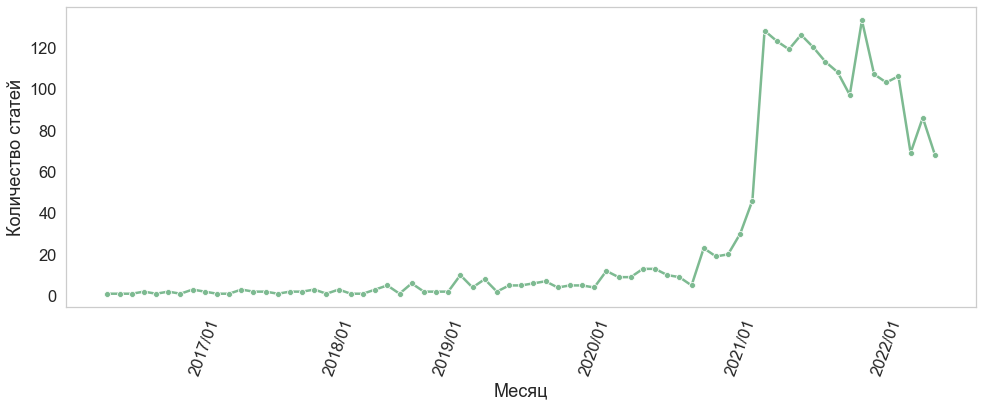

In [181]:
plt.figure(figsize=(14,6))
sns.set_style("whitegrid",{'axes.grid' : False})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

buf = df.groupby(['ym']).count().reset_index().sort_values('ym')

ax=sns.lineplot(data=buf, x="ym", y="href",  marker='o')
ax.set(xlabel='Месяц', ylabel='Количество статей')
plt.xticks(rotation=70)
plt.tight_layout()
n = buf.loc[:,['ym']].copy()
n.loc[buf['ym'].str.contains('/01') == False,['ym']] = ''

ax.set_xticklabels(n['ym'].to_list());


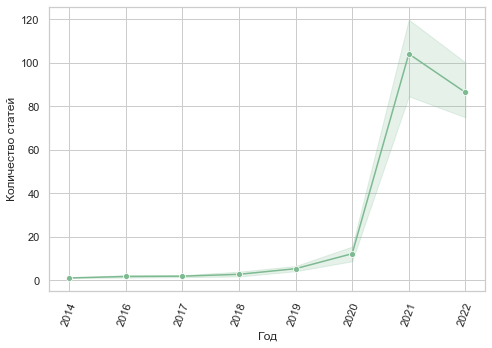

In [169]:
plt.figure(figsize=(7,5))
sns.set_style("whitegrid",{'axes.grid' : True})
#sns.set_style("whitegrid")
buf = df.groupby(['y']).count().reset_index().sort_values('y')

ax=sns.lineplot(data=buf, x="y", y="href", palette='crest', marker='o')
ax.set(xlabel='Год', ylabel='Количество статей')
plt.xticks(rotation=70)
plt.tight_layout()

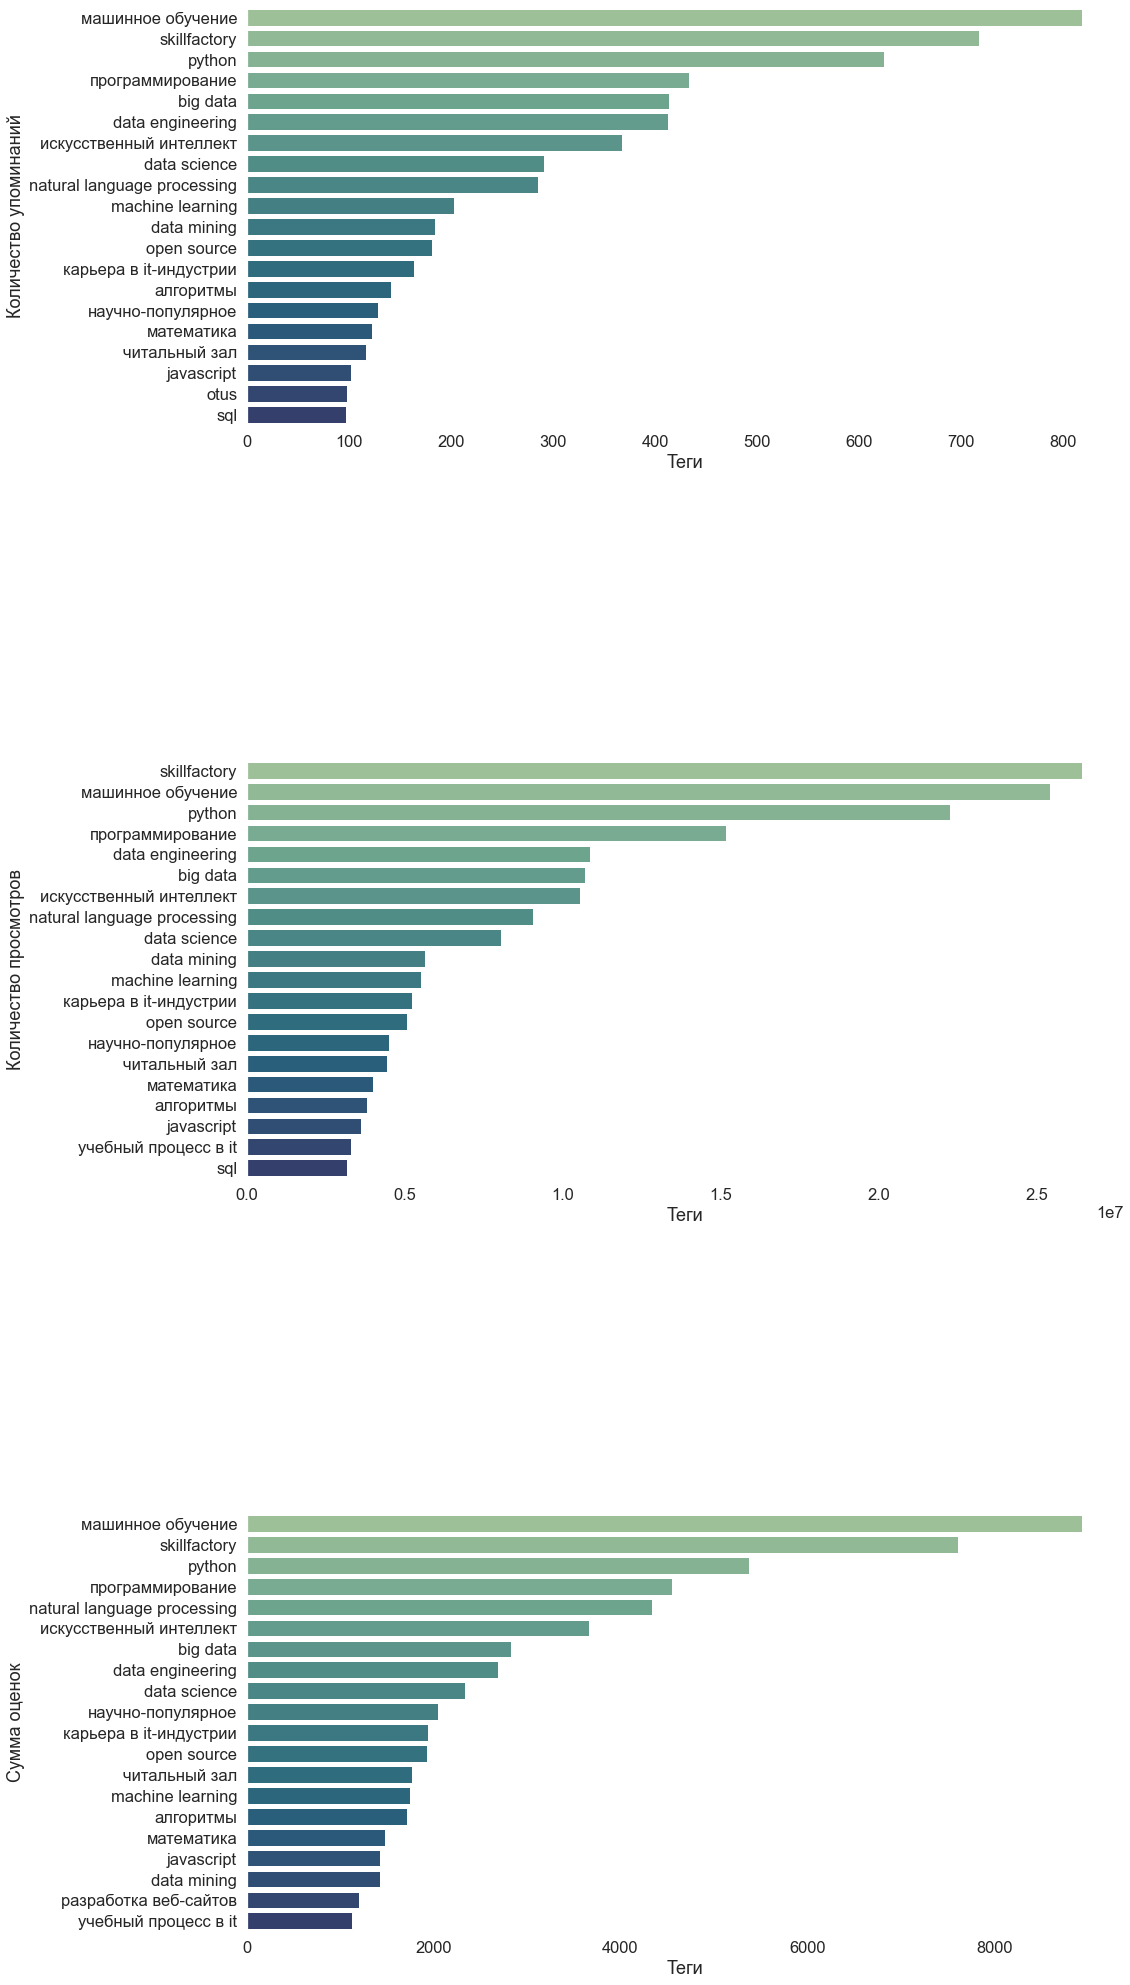

In [197]:

#plt.style.use('fivethirtyeight')
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

fig, axes = plt.subplots(3, 1, figsize=(14, 33))
plt.subplots_adjust(hspace = .8)

buf = tags.groupby('hub_tags').count().reset_index()
sns.barplot(data=buf.sort_values(['view'],ascending=False).head(20), y='hub_tags', x='view', ax=axes[0], palette="crest")


buf = tags.groupby('hub_tags').sum().reset_index()
sns.barplot(data=buf.sort_values(['view'],ascending=False).head(20), y='hub_tags', x='view', ax=axes[1], palette="crest")
sns.barplot(data=buf.sort_values(['score'],ascending=False).head(20), y='hub_tags', x='score', ax=axes[2], palette="crest")

axes[0].set(xlabel='Теги', ylabel='Количество упоминаний')
#axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation = 90);

axes[1].set(xlabel='Теги', ylabel='Количество просмотров')
#axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation = 90);

axes[2].set(xlabel='Теги', ylabel='Сумма оценок')
#axes[2].set_xticklabels(axes[1].get_xticklabels(),rotation = 90);


sns.set_palette(palette="crest")

Интересно, что по количеству просмотров и по количесву упоминаний впреди находится skillfactory

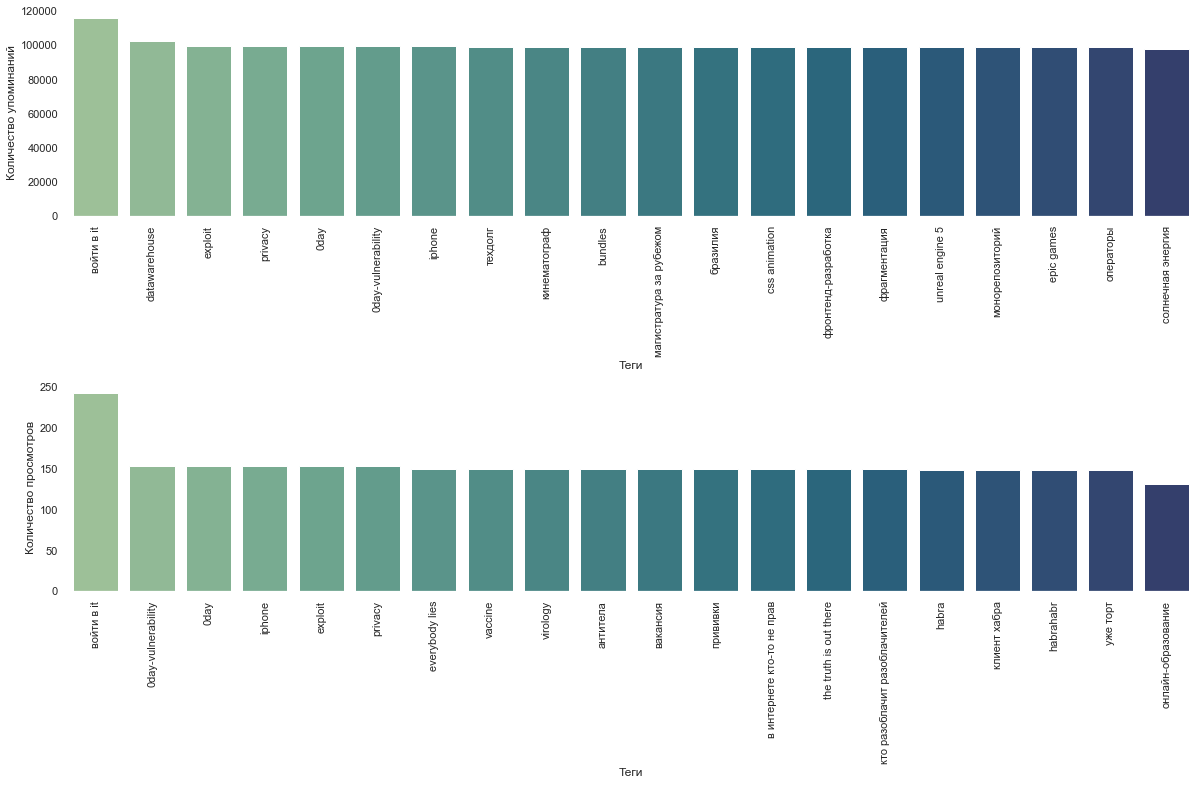

In [115]:
plt.style.use('fivethirtyeight')
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
fig, axes = plt.subplots(2, 1, figsize=(18, 10))
plt.subplots_adjust(hspace = 0.8)

buf = tags.groupby('hub_tags').mean().reset_index()
sns.barplot(data=buf.sort_values(['view'],ascending=False).head(20), x='hub_tags', y='view', ax=axes[0], palette="crest")
sns.barplot(data=buf.sort_values(['score'],ascending=False).head(20), x='hub_tags', y='score', ax=axes[1], palette="crest")

axes[0].set(xlabel='Теги', ylabel='Количество упоминаний')
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation = 90);

axes[1].set(xlabel='Теги', ylabel='Количество просмотров')
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation = 90);

#axes[2].set(xlabel='Теги', ylabel='Сумма оценок')
#axes[2].set_xticklabels(axes[2].get_xticklabels(),rotation = 90);


Упоминание некоторых тегов по месяцам

In [219]:
tags

,hub_tags,ym,view,score,bookmark,comment,y
0,skillfactory,2022/05,29000,15,23,0,2022
0,python,2022/05,29000,15,23,0,2022
0,gan,2022/05,29000,15,23,0,2022
0,стиль,2022/05,29000,15,23,0,2022
0,программирование,2022/05,29000,15,23,0,2022
...,...,...,...,...,...,...,...
3834,new professions lab,2017/10,13000,5,98,4,2017
3834,data mining,2017/10,13000,5,98,4,2017
3834,серверное администрирование,2017/10,13000,5,98,4,2017
3834,администрирование баз данных,2017/10,13000,5,98,4,2017


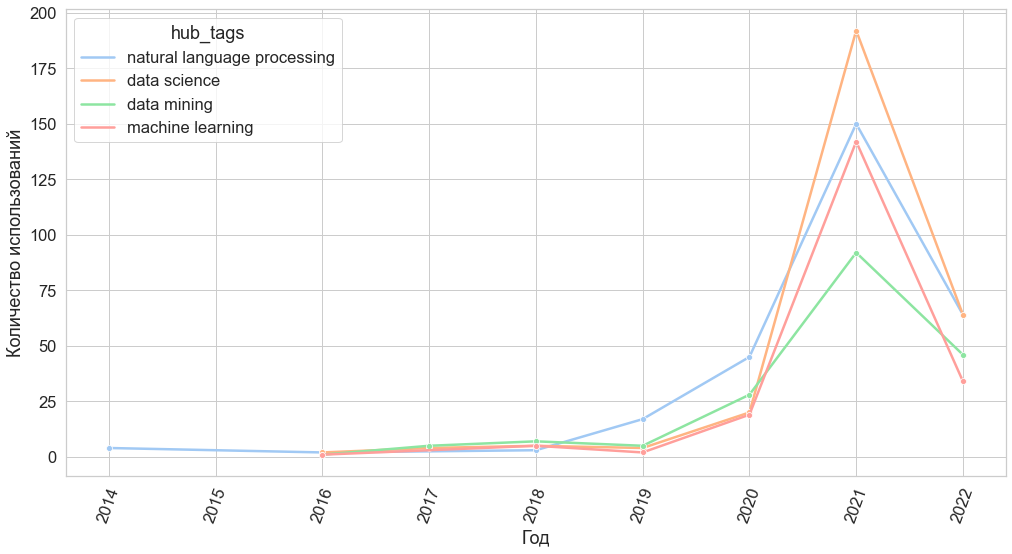

In [221]:
plt.figure(figsize=(15,8))
sns.set_style("whitegrid",{'axes.grid' : True})


buf = tags.groupby(['hub_tags', 'y']).count().reset_index().sort_values('y')
#n = buf.loc[:,['y']].groupby(['y']).count().reset_index().sort_values('y').copy()
#n.loc[n['y'].str.contains('/01') == False, ['y']] = ''


ax=sns.lineplot(data=buf.loc[buf['hub_tags'].isin(['data science',
                                                   'natural language processing',
                                                    'machine learning',
                                                      'data mining']) , :], 
                x="y", y="view", hue='hub_tags', palette="pastel", marker='o')

#ax.set_xticklabels(n['ym'].to_list());
ax.set(xlabel='Год', ylabel='Количество использований')

plt.xticks(rotation=70);
#plt.tight_layout()



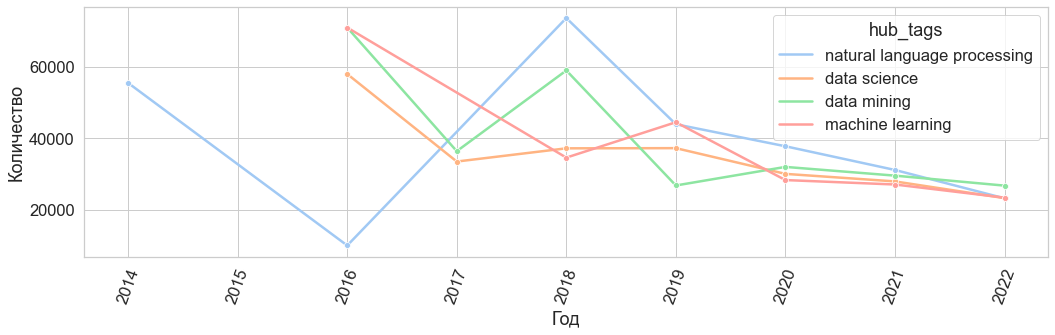

In [224]:
plt.figure(figsize=(15,5))
sns.set_style("whitegrid",{'axes.grid' : True})

buf = tags.groupby(['hub_tags', 'y']).mean().reset_index().sort_values('y')

ax=sns.lineplot(data=buf.loc[buf['hub_tags'].isin(['data science',
                                                   'natural language processing',
                                                    'machine learning',
                                                      'data mining']) , :], 
                x="y", y="view", hue='hub_tags', palette="pastel", marker='o')

ax.set(xlabel='Год', ylabel='Количество')
plt.xticks(rotation=70)
plt.tight_layout()

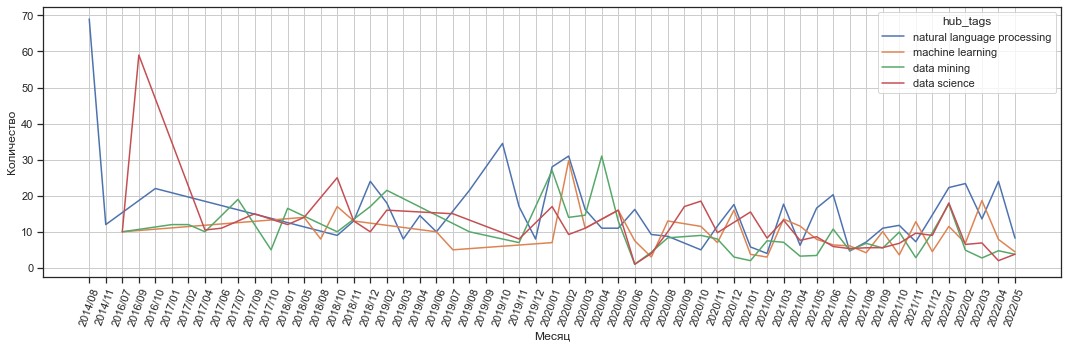

In [152]:
plt.figure(figsize=(15,5))
sns.set_style("ticks",{'axes.grid' : True})

buf = tags.groupby(['hub_tags', 'ym']).mean().reset_index().sort_values('ym')

ax=sns.lineplot(data=buf.loc[buf['hub_tags'].isin(['data science',
                                                   'natural language processing',
                                                    'machine learning',
                                                      'data mining']) , :], 
                x="ym", y="score", hue='hub_tags')

ax.set(xlabel='Месяц', ylabel='Количество')
plt.xticks(rotation=70)
plt.tight_layout()

Резкий рост всех представленных тегов приходится с конца 2020 года, пики -- на середину 2021
Также наблюдается небольшой всплеск в начале 2020 года

Выделить сущности, Облако слов

In [125]:
names = df.loc[:, ['article_names' , 'ym','view', 'score', 'bookmark', 'comment']].explode('article_names')
names['article_names'] = names['article_names'].astype(str)
names['y'] = names['ym'].str.replace(r'/\d\d', '')

2022-05-29 21:20:05,308 [9772] WARNING  py.warnings:109: [JupyterRequire] <ipython-input-125-b8d7336acaae>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  names['y'] = names['ym'].str.replace(r'/\d\d', '')



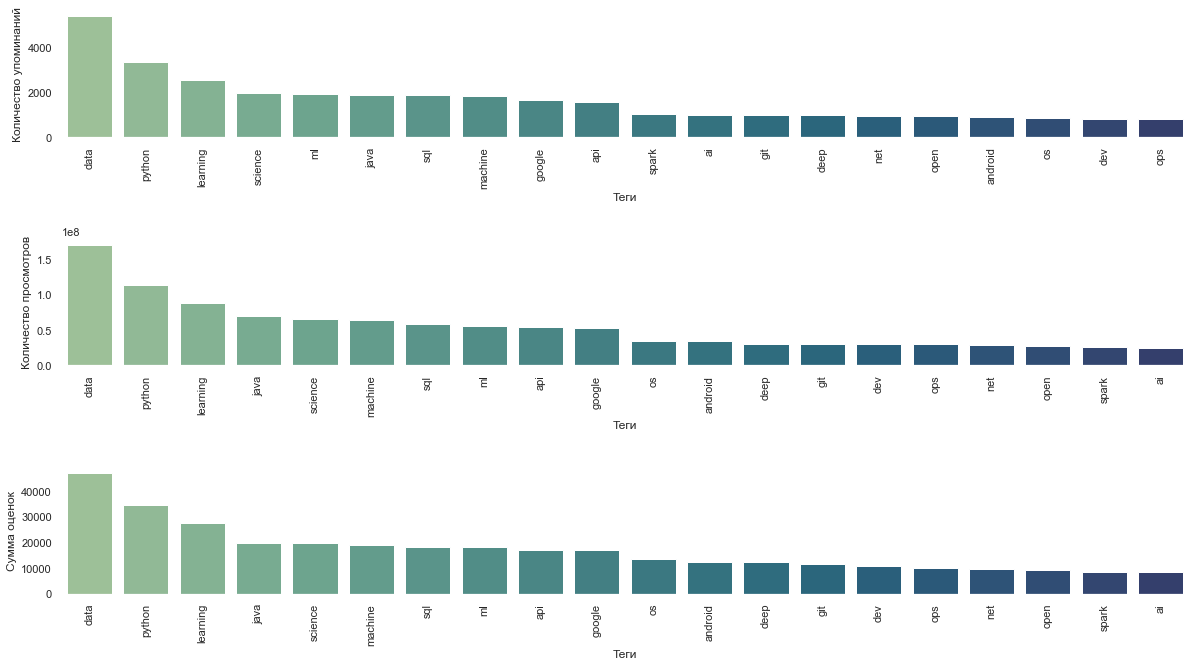

In [126]:
plt.style.use('fivethirtyeight')
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
fig, axes = plt.subplots(3, 1, figsize=(18, 10))
plt.subplots_adjust(hspace = 0.8)

buf = names.groupby('article_names').count().reset_index()
sns.barplot(data=buf.sort_values(['view'],ascending=False).head(20), x='article_names', y='view', ax=axes[0], palette="crest")


buf = names.groupby('article_names').sum().reset_index()
sns.barplot(data=buf.sort_values(['view'],ascending=False).head(20), x='article_names', y='view', ax=axes[1], palette="crest")
sns.barplot(data=buf.sort_values(['score'],ascending=False).head(20), x='article_names', y='score', ax=axes[2], palette="crest")

axes[0].set(xlabel='Теги', ylabel='Количество упоминаний')
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation = 90);

axes[1].set(xlabel='Теги', ylabel='Количество просмотров')
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation = 90);

axes[2].set(xlabel='Теги', ylabel='Сумма оценок')
axes[2].set_xticklabels(axes[1].get_xticklabels(),rotation = 90);


In [245]:
ax.get_yticklabels()

[Text(0, 0.0, ''),
 Text(0, 50.0, ''),
 Text(0, 100.0, ''),
 Text(0, 150.0, ''),
 Text(0, 200.0, ''),
 Text(0, 250.0, ''),
 Text(0, 300.0, ''),
 Text(0, 350.0, ''),
 Text(0, 400.0, ''),
 Text(0, 450.0, '')]

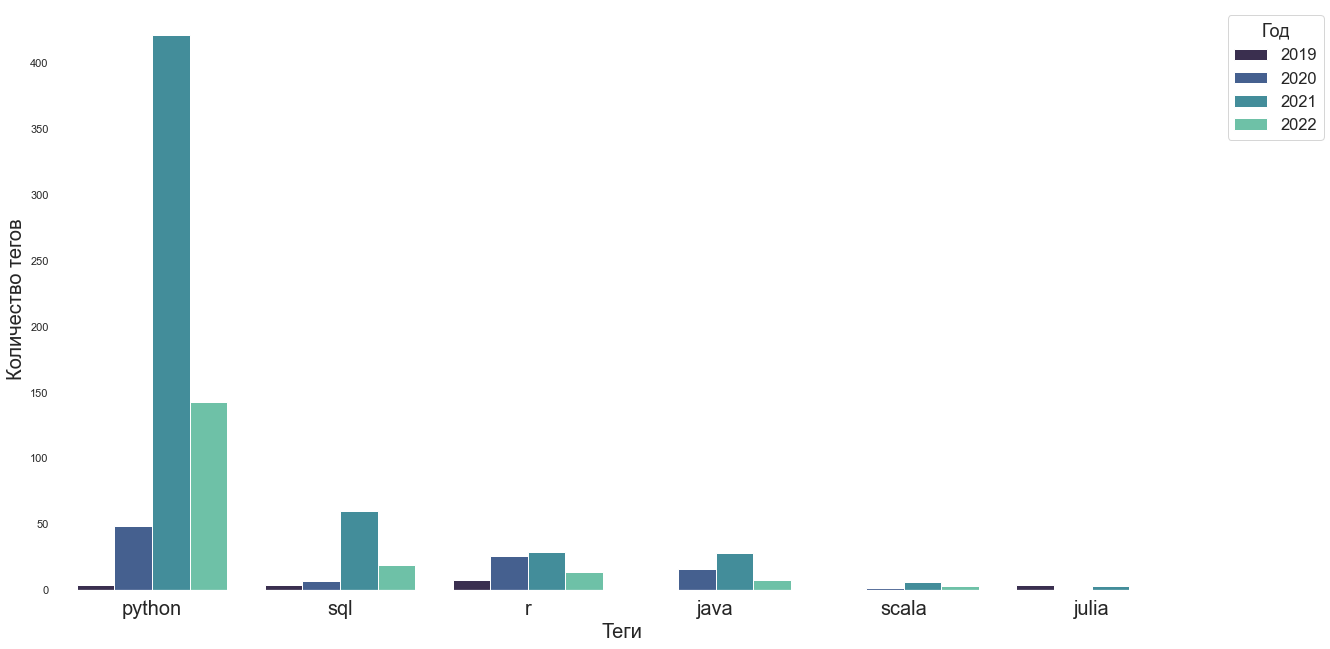

In [253]:


sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
fig, ax = plt.subplots(1, 1, figsize=(18, 10))


buf = tags.groupby(['hub_tags', 'y']).count().reset_index()
buf = buf.loc[buf['hub_tags'].isin(['python', 'r', 'scala', 'sql', 'java', 'julia']),:]
buf = buf.loc[buf['y'].isin([ 2019, 2020, 2021, 2022]),:]

sns.set( font_scale=1.5)
ax = sns.barplot(data=buf.sort_values(['view'],ascending=False), x='hub_tags', y='view', hue='y', palette="mako")
ax.legend(     bbox_to_anchor= (1.03, 1), \
               title="Год", \
               title_fontsize = 18, \
               shadow = False, \
               facecolor = 'white');

ax.set_xlabel('Теги',fontsize = 20, )
ax.set_ylabel('Количество тегов',fontsize = 20 )


ax.set_xticklabels(ax.get_xticklabels(), fontsize = 20, );


(-0.5, 399.5, 199.5, -0.5)

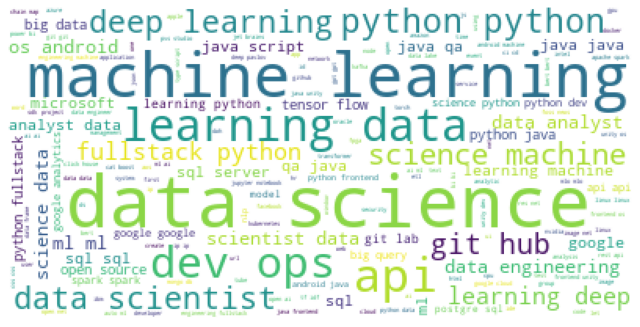

In [217]:
plt.figure(figsize=(10,10))

text_raw = " ".join(names['article_names'].to_list())
w = WordCloud(background_color='white').generate(text_raw)
plt.imshow(w)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

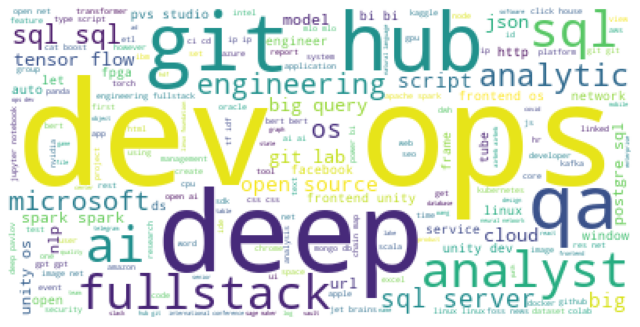

In [219]:
plt.figure(figsize=(10,10))

text_raw = " ".join(names['article_names'].to_list())
w = WordCloud(background_color='white', stopwords=['data', 'science', 'machine', 
                                                   'learning', 'scientist', 'python', 
                                                   'java', 'api', 'google', 'ml', 'android']).generate(text_raw)
plt.imshow(w)
plt.axis('off')

In [11]:
df['article_text_new'] = df['article_text'].apply(clear_data, deep=True)

In [12]:
df['article_text_split'] = df['article_text_new'].str.split()
article_text = df.loc[:, ['ym', 'article_text_split', 'view']].explode('article_text_split')

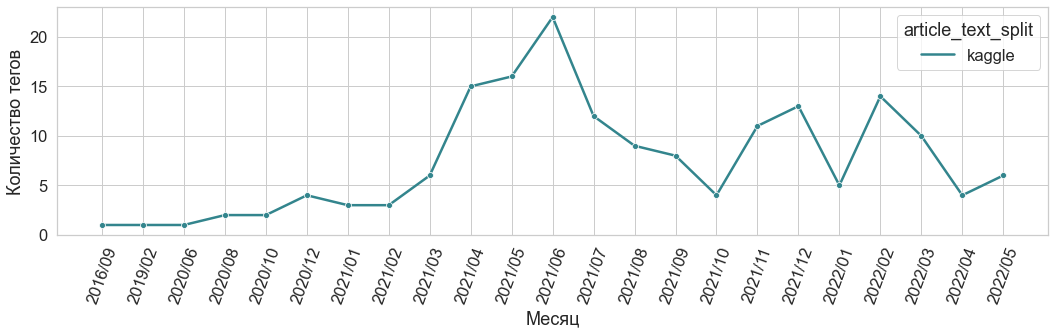

In [258]:
plt.figure(figsize=(15,5))
sns.set_style("whitegrid",{'axes.grid' : True})

buf = article_text.groupby(['article_text_split', 'ym']).count().reset_index().sort_values('ym')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ax=sns.lineplot(data=buf.loc[buf['article_text_split'].isin(['kaggle'], 
                                                               ) , :], 
                x="ym", y="view", hue='article_text_split', palette='crest', marker='o')


ax.set(xlabel='Месяц', ylabel='Количество тегов')
plt.xticks(rotation=70)
plt.tight_layout()

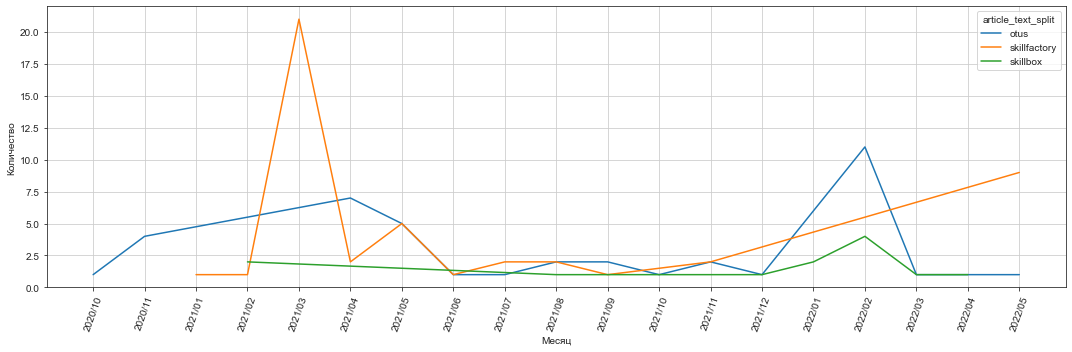

In [14]:
plt.figure(figsize=(15,5))
sns.set_style("ticks",{'axes.grid' : True})

buf = article_text.groupby(['article_text_split', 'ym']).count().reset_index().sort_values('ym')

ax=sns.lineplot(data=buf.loc[buf['article_text_split'].isin(['otus', 'skillfactory', 'skillbox', 'netology'], 
                                                               ) , :], 
                x="ym", y="view", hue='article_text_split')

ax.set(xlabel='Месяц', ylabel='Количество')
plt.xticks(rotation=70)
plt.tight_layout()

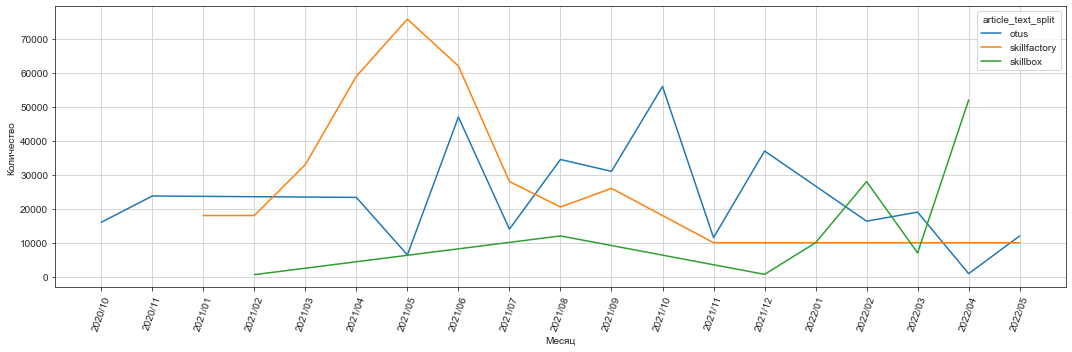

In [15]:
plt.figure(figsize=(15,5))
sns.set_style("ticks",{'axes.grid' : True})

buf = article_text.groupby(['article_text_split', 'ym']).mean().reset_index().sort_values('ym')

ax=sns.lineplot(data=buf.loc[buf['article_text_split'].isin(['otus', 'skillfactory', 'skillbox', 'netology'], 
                                                               ) , :], 
                x="ym", y="view", hue='article_text_split')

ax.set(xlabel='Месяц', ylabel='Количество')
plt.xticks(rotation=70)
plt.tight_layout()

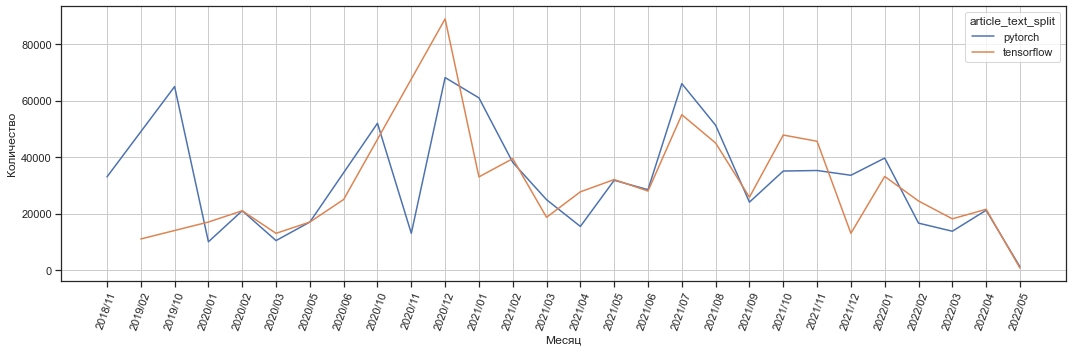

In [235]:
plt.figure(figsize=(15,5))
sns.set_style("ticks",{'axes.grid' : True})

buf = article_text.groupby(['article_text_split', 'ym']).mean().reset_index().sort_values('ym')

ax=sns.lineplot(data=buf.loc[buf['article_text_split'].isin(['tensorflow', 'keras', 'pytorch', 'керас'], 
                                                               ) , :], 
                x="ym", y="view", hue='article_text_split')

ax.set(xlabel='Месяц', ylabel='Количество')
plt.xticks(rotation=70)
plt.tight_layout()

2022-05-29 19:42:09,119 [9772] WARNING  py.warnings:109: [JupyterRequire] <ipython-input-70-44ac59b8edc8>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  article_text['y'] = article_text['ym'].str.replace(r'/\d\d', '')



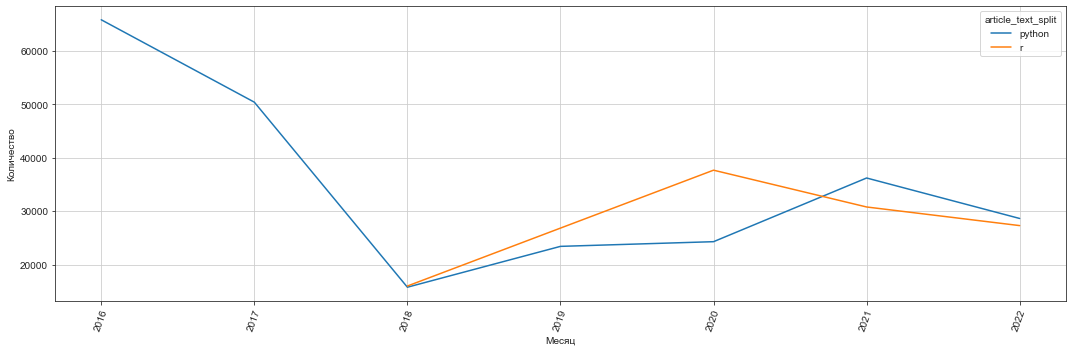

In [70]:
plt.figure(figsize=(15,5))
sns.set_style("ticks",{'axes.grid' : True})
article_text['y'] = article_text['ym'].str.replace(r'/\d\d', '')
buf = article_text.groupby(['article_text_split', 'y']).mean().reset_index().sort_values('y')

ax=sns.lineplot(data=buf.loc[buf['article_text_split'].isin(['python', 'r'], 
                                                               ) , :], 
                x="y", y="view", hue='article_text_split')

ax.set(xlabel='Месяц', ylabel='Количество')
plt.xticks(rotation=70)
plt.tight_layout()

2022-05-29 20:19:16,477 [9772] WARNING  py.warnings:109: [JupyterRequire] <ipython-input-74-66b1fb7fbdeb>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  article_text['y'] = article_text['ym'].str.replace(r'/\d\d', '')

2022-05-29 20:19:22,144 [9772] WARNING  matplotlib.text:690: [JupyterRequire] posx and posy should be finite values
2022-05-29 20:19:22,144 [9772] WARNING  matplotlib.text:690: [JupyterRequire] posx and posy should be finite values
2022-05-29 20:19:22,161 [9772] WARNING  matplotlib.text:690: [JupyterRequire] posx and posy should be finite values
2022-05-29 20:19:22,432 [9772] WARNING  matplotlib.text:690: [JupyterRequire] posx and posy should be finite values
2022-05-29 20:19:22,436 [9772] WARNING  matplotlib.text:690: [JupyterRequire] posx and posy should be finite values
2022-05-29 20:19:22,445 [9772] WARNING  matplotlib.text:690: [JupyterRequire] posx and posy should be finite values


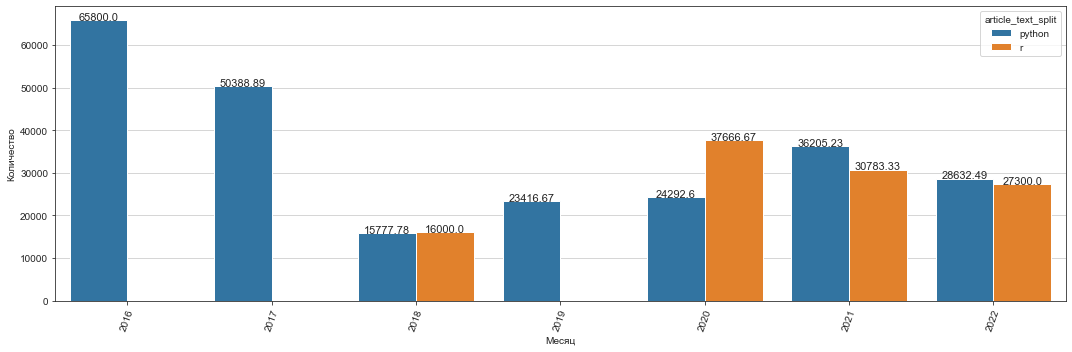

In [74]:
plt.figure(figsize=(15,5))
sns.set_style("ticks",{'axes.grid' : True})
article_text['y'] = article_text['ym'].str.replace(r'/\d\d', '')
buf = article_text.groupby(['article_text_split', 'y']).mean().reset_index().sort_values('y')
buf["view_day"] = buf["view"].round(2) 
ax=sns.barplot(data=buf.loc[buf['article_text_split'].isin(['python', 'r'], 
                                                               ) , :], 
                x="y", y="view_day", hue='article_text_split')

ax.set(xlabel='Месяц', ylabel='Количество')
plt.xticks(rotation=70)
plt.tight_layout()

for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()  / 2, rect.get_height()+ 0.95,rect.get_height(),horizontalalignment='center', fontsize = 11)

In [16]:
vectorizer = TfidfVectorizer(max_features = 200, ngram_range=(1,3)) 
vectors = vectorizer.fit_transform(df['article_text_new'])

In [63]:
df1 = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names())
df1 = pd.concat([df1, df.loc[:,['view_day', 'score_day', 'bookmark_day', 'comment_day']]], axis=1)
df1 = df1.fillna(0)

In [64]:
# Настройка функции t-SNE.
embed = TSNE(
    n_components=2,
    perplexity=10,
    early_exaggeration=12, 
    learning_rate=200, 
    n_iter=5000, 
    n_iter_without_progress=300,
    min_grad_norm=0.0000001, 
    metric='euclidean', 
    init='random', #{'random', 'pca'} или ndarray формы (n_samples, n_components), значение по умолчанию='random'. Инициализация вложения.
    verbose=0, 
    random_state=42, 
    method='barnes_hut', 
    angle=0.5, 
    n_jobs=-1, 
)

# Преобразование X
X_embedded = embed.fit_transform(df1.to_numpy())

# Вывод результатов
print('New Shape of X: ', X_embedded.shape)
print('Kullback-Leibler divergence after optimization: ', embed.kl_divergence_)
print('No. of iterations: ', embed.n_iter_)
#вывод('Embedding vectors: ', embed.embedding_)

New Shape of X:  (2645, 2)
Kullback-Leibler divergence after optimization:  0.5697866082191467
No. of iterations:  4999


In [82]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

def determine_k(embeddings):
    k_min = 10
    clusters = [x for x in range(2, k_min * 11)]
    metrics = []
    for i in clusters:
        metrics.append((KMeans(n_clusters=i).fit(embeddings)).inertia_)
    k = elbow(k_min, clusters, metrics)
    return k

def elbow(k_min, clusters, metrics):
    score = []

    for i in range(k_min, clusters[-3]):
        y1 = np.array(metrics)[:i + 1]
        y2 = np.array(metrics)[i:]
    
        df1 = pd.DataFrame({'x': clusters[:i + 1], 'y': y1})
        df2 = pd.DataFrame({'x': clusters[i:], 'y': y2})
    
        reg1 = LinearRegression().fit(np.asarray(df1.x).reshape(-1, 1), df1.y)
        reg2 = LinearRegression().fit(np.asarray(df2.x).reshape(-1, 1), df2.y)

        y1_pred = reg1.predict(np.asarray(df1.x).reshape(-1, 1))
        y2_pred = reg2.predict(np.asarray(df2.x).reshape(-1, 1))    
        
        score.append(mean_squared_error(y1, y1_pred) + mean_squared_error(y2, y2_pred))

    return np.argmin(score) + k_min

determine_k(X_embedded)

106

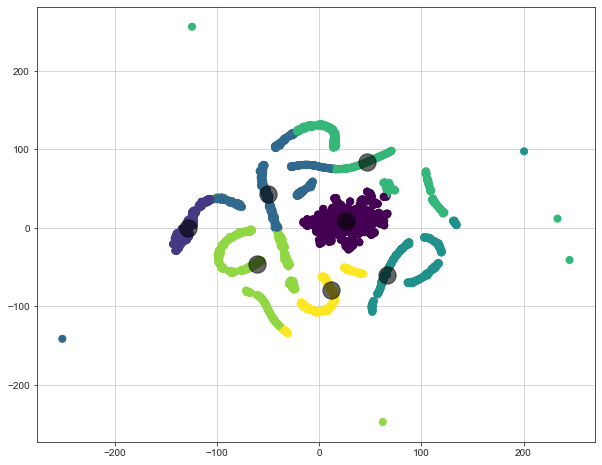

In [84]:
nc = 7
gmm = GaussianMixture(n_components=nc, covariance_type='full').fit(X_embedded)
prediction_gmm = gmm.predict(X_embedded)
probs = gmm.predict_proba(X_embedded)

centers = np.zeros((nc,2))
for i in range(nc):
    density = mvn(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(X_embedded)
    centers[i, :] = X_embedded[np.argmax(density)]

plt.figure(figsize = (10,8))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1],c=prediction_gmm ,s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

План
1. Самые популярные и непопулярные теги по количеству, просмотру, упоминанию, комментариям
2. Сымые популярные авторы по количеству, просмотру, упоминанию
3. Упоминание некоторых тегов по месяцам
4. Выделить сущности, Облако слов
5. Кластеризация